In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

--2020-08-07 03:25:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   235MB/s    in 0.6s    

2020-08-07 03:25:00 (235 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-08-07 03:25:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

**Model** **1**

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
# Make all the layers in the pre-trained model non-trainable
for layer in base_model.layers:
  layer.trainable = False

In [6]:
last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1280)


In [14]:
from tensorflow.keras import layers
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(252, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)  

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)  


model = tf.keras.Model(base_model.input, x)

In [15]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

#model.summary()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(160, 160),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(160, 160),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [17]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)

Epoch 1/5
9/9 [==============================] - 29s 3s/step - loss: 0.9930 - accuracy: 0.8218 - val_loss: 8.5413e-04 - val_accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 28s 3s/step - loss: 0.0263 - accuracy: 0.9922 - val_loss: 7.5588e-04 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 28s 3s/step - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 29s 3s/step - loss: 0.0133 - accuracy: 0.9951 - val_loss: 5.8122e-04 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 29s 3s/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 5.8734e-04 - val_accuracy: 1.0000


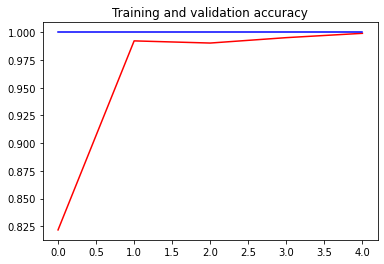

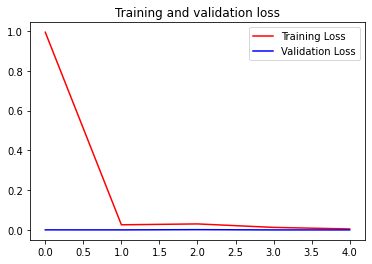

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.save('horse_human.h5')

In [20]:
import os
print(str(os.path.getsize('./horse_human.h5')/1000000) + 'MB')

74.032624MB


**Model 2**

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
# Make all the layers in the pre-trained model non-trainable
for layer in base_model.layers:
  layer.trainable = False

In [6]:
last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1280)


In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [8]:
x = global_average_layer(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

In [9]:
model = tf.keras.Model(base_model.input, outputs)

In [10]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(160, 160),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(160, 160),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
9/9 [==============================] - 29s 3s/step - loss: 6.4161 - accuracy: 0.4489 - val_loss: 6.8396 - val_accuracy: 0.4922
Epoch 2/50
9/9 [==============================] - 28s 3s/step - loss: 5.7542 - accuracy: 0.4703 - val_loss: 5.7125 - val_accuracy: 0.4883
Epoch 3/50
9/9 [==============================] - 28s 3s/step - loss: 5.3706 - accuracy: 0.5102 - val_loss: 4.9602 - val_accuracy: 0.5195
Epoch 4/50
9/9 [==============================] - 28s 3s/step - loss: 5.0483 - accuracy: 0.5112 - val_loss: 4.8815 - val_accuracy: 0.5195
Epoch 5/50
9/9 [==============================] - 28s 3s/step - loss: 4.8226 - accuracy: 0.5521 - val_loss: 4.5521 - val_accuracy: 0.5352
Epoch 6/50
9/9 [==============================] - 29s 3s/step - loss: 4.5924 - accuracy: 0.5443 - val_loss: 4.1545 - val_accuracy: 0.5586
Epoch 7/50
9/9 [==============================] - 29s 3s/step - loss: 4.5689 - accuracy: 0.5307 

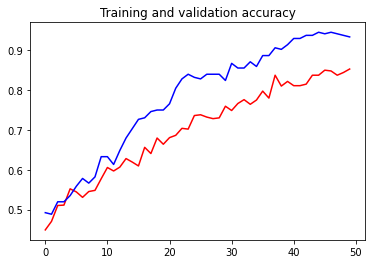

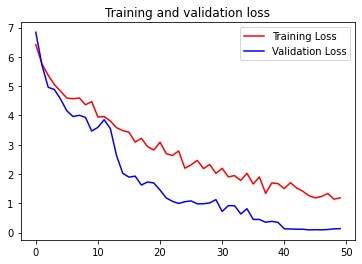

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save('horse_human1.h5')

In [17]:
import os
print(str(os.path.getsize('./horse_human1.h5')/1000000) + 'MB')

9.517792MB
